In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_data=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train_data = train_data.set_index('PassengerId')
train_data = train_data.drop(['Name', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1) #for the time we are not going to use RoomService,FoodCourt,etc.

In [3]:
train_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported
PassengerId,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,True


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   8492 non-null   object 
 1   CryoSleep    8476 non-null   object 
 2   Cabin        8494 non-null   object 
 3   Destination  8511 non-null   object 
 4   Age          8514 non-null   float64
 5   VIP          8490 non-null   object 
 6   Transported  8693 non-null   bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 483.9+ KB


There is missing information on almost all of the attributes.

In [5]:
train_data.isna().sum()

HomePlanet     201
CryoSleep      217
Cabin          199
Destination    182
Age            179
VIP            203
Transported      0
dtype: int64

<h3>EDA</h3>

In [6]:
train_data.nunique()

HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
Age              80
VIP               2
Transported       2
dtype: int64

Separate categorical and numerical features, and target variable.

In [7]:
cat_attr = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
num_attr = ['Age']
target = 'Transported'

Information on Cabin is not usefull unless we transformed it.

<AxesSubplot:xlabel='Age', ylabel='Count'>

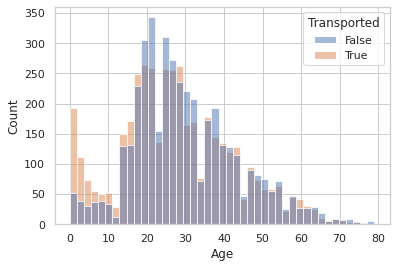

In [8]:
sns.histplot(train_data, x='Age', hue=target)

0-20 year olds are more likely to be transported, 20-40 year olds are less likely to be transported.

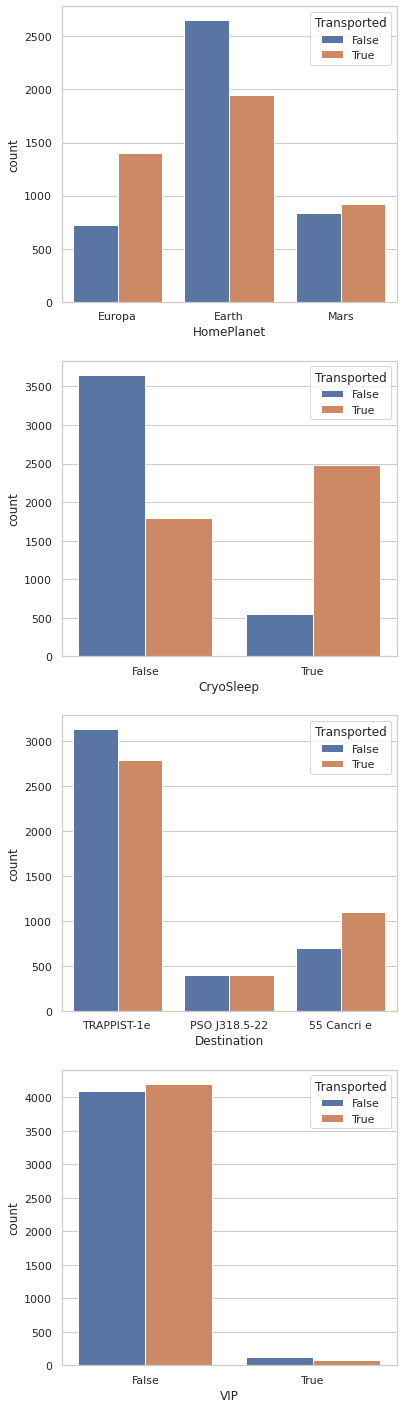

In [9]:
fig, axes = plt.subplots(len(cat_attr),1, figsize=(6,25))
i = 0
for axis in axes:
    sns.countplot(data=train_data, x=cat_attr[i], hue=target, ax=axis)
    i+=1
plt.show()

* People coming from Earth are less likely to be transported, meanwhile people from Europa are more likely to be transported.
* People in cryosleep are more likely to be transported.
* Few people travel VIP.

Now we are going to separate Cabin into Deck, Num and Side. First we create a mock value for missing cabins, and we make sure that the value is not present in the train or test set.

In [10]:
na_cabin = 'Z/9999/Z'
print('Training data impossible value counts (should be 0):', train_data.loc[train_data['Cabin'] == na_cabin, 'Cabin'].count())
print('Test data impossible value counts (should be 0):', test_data.loc[test_data['Cabin'] == 'na_cabin', 'Cabin'].count())


Training data impossible value counts (should be 0): 0
Test data impossible value counts (should be 0): 0


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['Cabin'].fillna('Z/9999/Z', inplace=True)
        X['Cabin_Deck'] = X['Cabin'].apply(lambda x:x.split('/')[0])
        X['Cabin_Number'] = X['Cabin'].apply(lambda x:x.split('/')[1]).astype(int)
        X['Cabin_Side'] = X['Cabin'].apply(lambda x:x.split('/')[2])
        X.drop('Cabin', axis=1, inplace=True)
        X.loc[X['Cabin_Deck'] == 'Z', 'Cabin_Deck'] = np.nan
        X.loc[X['Cabin_Number'] == 9999, 'Cabin_Number'] = np.nan
        X.loc[X['Cabin_Side'] == 'Z', 'Cabin_Side'] = np.nan
        return X


In [12]:
trns = CabinTransformer()
trns.fit_transform(test_data)
trns.fit_transform(train_data)

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Cabin_Deck,Cabin_Number,Cabin_Side
PassengerId,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,False,B,0.0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,True,F,0.0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,False,A,0.0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,False,A,0.0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,True,F,1.0,S
...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,55 Cancri e,41.0,True,False,A,98.0,P
9278_01,Earth,True,PSO J318.5-22,18.0,False,False,G,1499.0,S
9279_01,Earth,False,TRAPPIST-1e,26.0,False,True,G,1500.0,S


Examine the new cabin features.

<AxesSubplot:xlabel='Cabin_Number', ylabel='Count'>

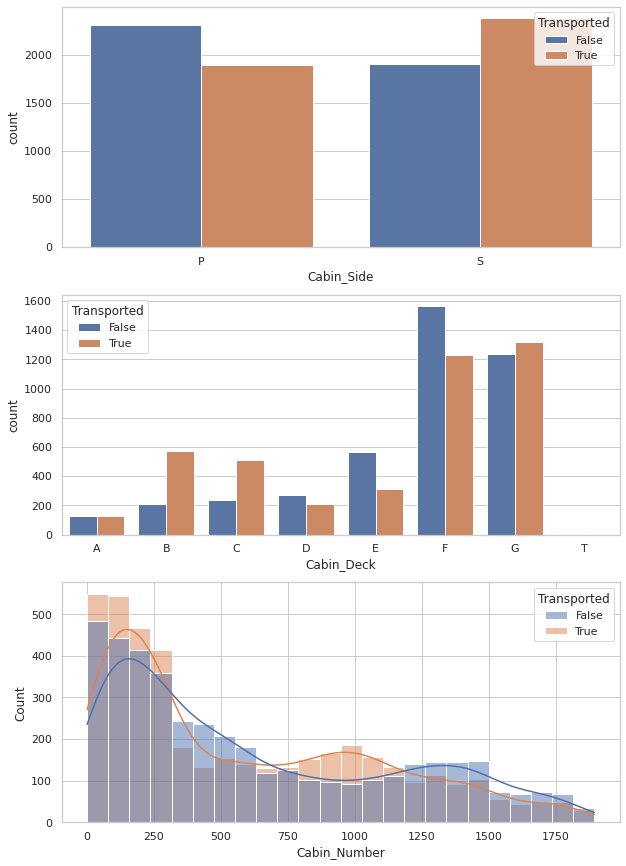

In [13]:
fig, axis = plt.subplots(3,1,figsize=(10,15))

sns.countplot(data=train_data, x='Cabin_Side', hue=target, ax=axis[0])
sns.countplot(data=train_data, x='Cabin_Deck', hue=target, ax=axis[1], order=['A','B','C','D','E','F','G','T'])
sns.histplot(data=train_data, x='Cabin_Number', hue=target, ax=axis[2], kde=True)

Group Cabin_Number into 0-300, 300-600, and so on.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

train_data.columns

cat_attr = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']
num_attr = ['Age', 'Cabin_Number']

train_y=train_data[target]
train_X=train_data.drop(target,axis=1)

In [15]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', cat_pipeline, cat_attr)
    
])

In [16]:
train_X = full_pipeline.fit_transform(train_X)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
cross_val_score(model,train_X,train_y,cv=5)

array([0.7027027 , 0.68142611, 0.65842438, 0.67779056, 0.7278481 ])

In [18]:
# class CabinGrouper(BaseEstimator, TransformerMixin):
#     def fit(self,X,y=None):
#         return self
#     def transform(self,X,y=None):
#         X['Cabin_Group']=0
#         for i in range()
#         return X


In [19]:
# features=['HomePlanet','CryoSleep','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'] #columns used 

# X_=train_data[features]
# X=pd.get_dummies(X_) # categorical data to numeric 
# y=train_data.Transported

# train_X,val_X,train_y,val_y=train_test_split(X,y)


In [20]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier

# model_random_forest=AdaBoostClassifier(RandomForestClassifier(random_state=0),random_state=0)
# model_random_forest.fit(train_X,train_y)

# predictions_random_forest=model_random_forest.predict(val_X)

# accuracy_random_forest=accuracy_score(val_y,predictions_random_forest)*100

In [21]:
# from sklearn.linear_model import SGDClassifier

# model_SGDC=SGDClassifier(random_state=0)
# model_SGDC.fit(train_X,train_y)

# predictions_SGDC=model_SGDC.predict(val_X)

# accuracy_SGDC=accuracy_score(val_y,predictions_SGDC)*100


In [22]:
from sklearn.neural_network import MLPClassifier   

# model_MLP=MLPClassifier(random_state=0,learning_rate_init=0.01)
# model_MLP.fit(train_X,train_y)

# predictions_MLP=model_MLP.predict(val_X)

# accuracy_MLP=accuracy_score(val_y,predictions_MLP)*100

In [23]:
# print(accuracy_random_forest,"% RandomForest+Ada")
# print(accuracy_SGDC,"% SGDC")
# print(accuracy_MLP,"% MLP")

MLP gives the best result.

In [24]:
# model_MLP_full_data=MLPClassifier(random_state=0,learning_rate_init=0.01)
# model_MLP_full_data.fit(X,y)

In [25]:
# test_data=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
# # test_data=test_data.dropna(axis=0)
# # test_X=pd.get_dummies(test_data[features])

In [26]:
# test_data.shape

In [27]:
# test_preds=model_MLP_full_data.predict(test_X)
# test_preds

In [28]:
# submission=pd.DataFrame({"PassengerId":test_data.PassengerId,"Transported":test_preds})
# submission.to_csv('submission.csv',index=False)